# BDD100K Object Detection - Exploration

This notebook provides a workspace for exploring the BDD100K dataset, developing models, and analyzing results.

## Project Structure

- **Phase 1**: Data Analysis (see `../data_analysis/`)
- **Phase 2**: Model Development (see `../model/`)
- **Phase 3**: Evaluation (see `../evaluation/`)

## Quick Start

1. Explore dataset using the parser
2. Visualize sample images with annotations
3. Load and test the model
4. Run inference on sample images

In [3]:
# Import required libraries
import sys
sys.path.append('..')

import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import torch

# Import project modules
from data_analysis.parser import BDD100KParser, DETECTION_CLASSES
from model.dataset import BDD100KDataset, get_transform
from model.model_architecture import get_faster_rcnn_model

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.10.0+cu128
CUDA available: True


2026-02-05 19:33:00,758 - data_analysis.parser - INFO - Loading annotations from directory: ../bdd100k_labels/100k/train
2026-02-05 19:33:01,470 - data_analysis.parser - INFO - Found 70000 JSON files
2026-02-05 19:33:30,395 - data_analysis.parser - INFO - Successfully loaded 70000 annotations


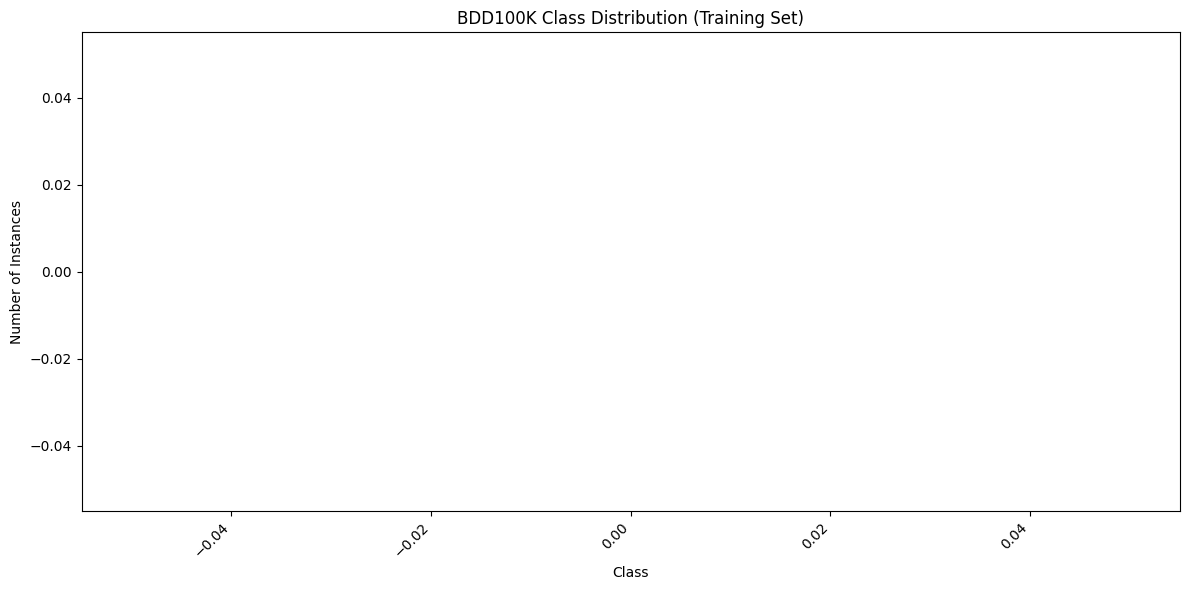


Total objects: 0

Top 5 classes:


In [5]:
# Load and parse training annotations
# Note: Labels are stored as individual JSON files (one per image) in the labels directory
train_labels_dir = "../bdd100k_labels/100k/train/"

# Initialize parser with labels directory
parser = BDD100KParser(train_labels_dir)

# Get class distribution
class_dist = parser.get_class_distribution()

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_dist.keys(), class_dist.values())
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('BDD100K Class Distribution (Training Set)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print statistics
total_objects = sum(class_dist.values())
print(f"\nTotal objects: {total_objects:,}")
print("\nTop 5 classes:")
for cls, count in sorted(class_dist.items(), key=lambda x: x[1], reverse=True)[:5]:
    percentage = (count / total_objects) * 100
    print(f"  {cls}: {count:,} ({percentage:.1f}%)")

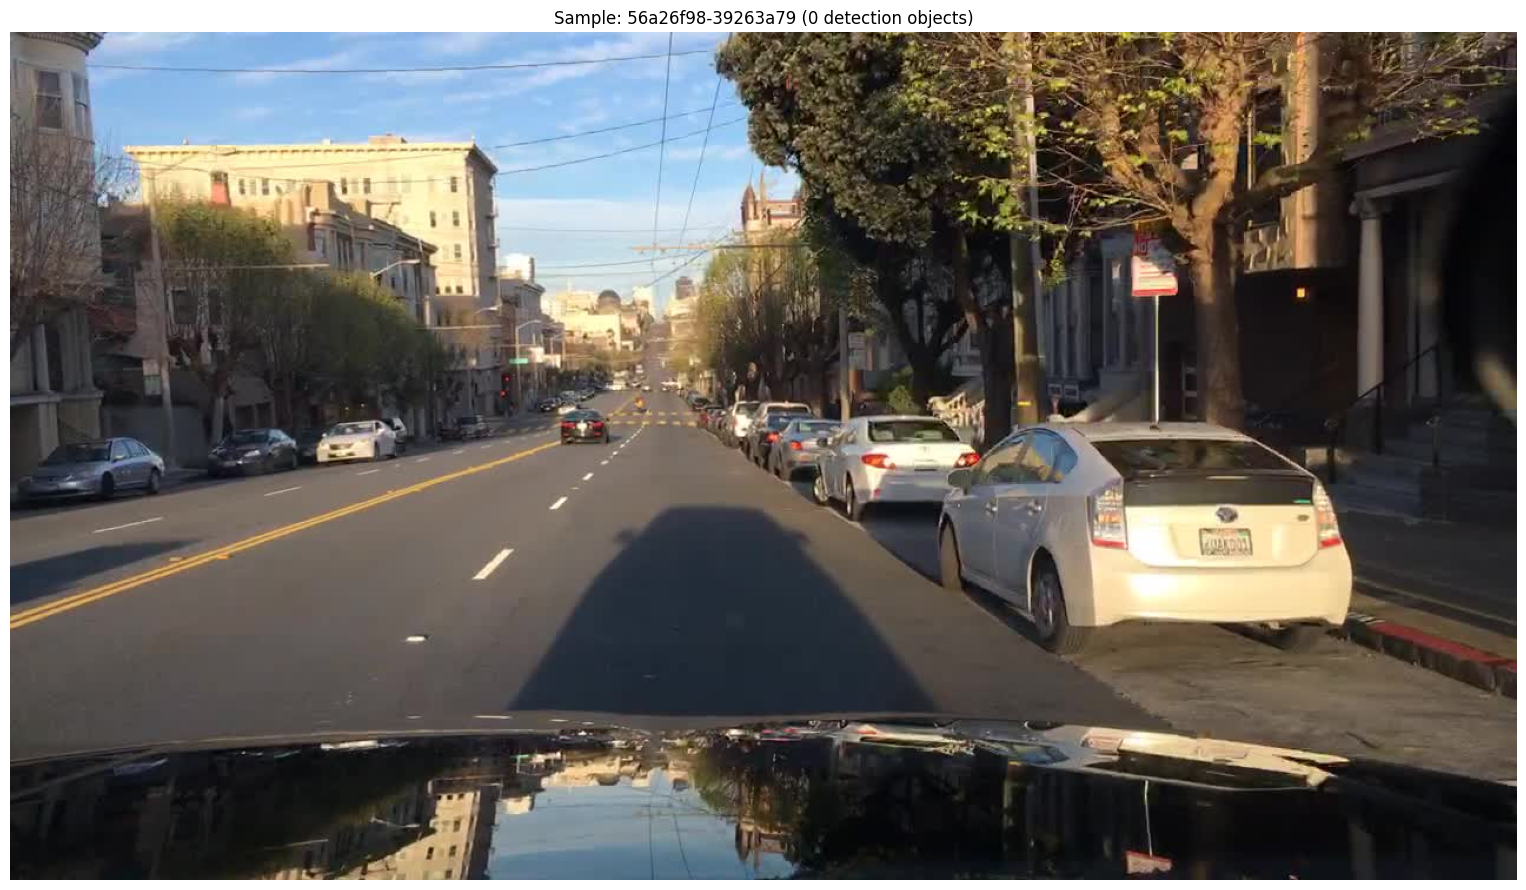


Image: 56a26f98-39263a79
Detection Objects: 0

Annotations:


In [17]:
# Visualize sample images with bounding boxes
import cv2

# Get annotations directly from parser
annotations = parser.annotations

# Select a random image
sample_annotation = annotations[1000]
sample_img_name = sample_annotation.get('name', '')

# Load image
img_path = f"../bdd100k_images_100k/100k/train/{sample_img_name}.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get labels for this image
labels = sample_annotation.get('labels', [])

# Draw bounding boxes
for label in labels:
    category = label.get('category', '')
    # Only draw detection classes
    if category not in DETECTION_CLASSES:
        continue
        
    box = label.get('box2d', {})
    if not box:
        continue
        
    x1, y1 = int(box['x1']), int(box['y1'])
    x2, y2 = int(box['x2']), int(box['y2'])
    
    # Draw rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Put label
    label_text = f"{category}"
    attributes = label.get('attributes', {})
    if attributes.get('occluded'):
        label_text += " (occ)"
    cv2.putText(image, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, (0, 255, 0), 2)

# Display
plt.figure(figsize=(16, 9))
plt.imshow(image)
plt.title(f"Sample: {sample_img_name} ({len([l for l in labels if l.get('category') in DETECTION_CLASSES])} detection objects)")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nImage: {sample_img_name}")
print(f"Detection Objects: {len([l for l in labels if l.get('category') in DETECTION_CLASSES])}")
print("\nAnnotations:")
for label in [l for l in labels if l.get('category') in DETECTION_CLASSES][:5]:  # Show first 5
    box = label.get('box2d', {})
    area = (box['x2']-box['x1'])*(box['y2']-box['y1']) if box else 0
    print(f"  - {label.get('category')}: box area = {area:.0f}")

In [14]:
# Load pre-trained Faster R-CNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (11 classes: 10 detection + 1 background)
model = get_faster_rcnn_model(num_classes=11, pretrained=True)
model = model.to(device)
model.eval()

print(f"\n✅ Model loaded successfully!")
print(f"Model type: Faster R-CNN with ResNet-50 FPN")
print(f"Number of classes: 11 (10 detection + background)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

2026-02-05 19:47:01,609 - model.model_architecture - INFO - Loading Faster R-CNN with ResNet-50 FPN: num_classes=11, pretrained=True


Using device: cuda


2026-02-05 19:47:02,219 - model.model_architecture - INFO - Model loaded with 11 classes



✅ Model loaded successfully!
Model type: Faster R-CNN with ResNet-50 FPN
Number of classes: 11 (10 detection + background)
Total parameters: 41,345,286
Trainable parameters: 41,122,886


In [18]:
# Run inference on a sample image
from torchvision.transforms import functional as F

# Load and preprocess image
img_path = f"../bdd100k_images_100k/100k/train/{sample_img_name}.jpg"
image_pil = Image.open(img_path).convert('RGB')
image_tensor = F.to_tensor(image_pil).unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    predictions = model(image_tensor)

pred = predictions[0]

# Filter predictions by confidence
score_threshold = 0.5
keep_idx = pred['scores'] >= score_threshold

pred_boxes = pred['boxes'][keep_idx].cpu().numpy()
pred_labels = pred['labels'][keep_idx].cpu().numpy()
pred_scores = pred['scores'][keep_idx].cpu().numpy()

print(f"Detected {len(pred_boxes)} objects with confidence >= {score_threshold}")
print("\nTop predictions:")
for i, (box, label, score) in enumerate(zip(pred_boxes[:5], pred_labels[:5], pred_scores[:5])):
    class_name = DETECTION_CLASSES[int(label)-1]
    print(f"  {i+1}. {class_name}: {score:.3f}")

Detected 0 objects with confidence >= 0.5

Top predictions:
